In [35]:
import re
import string
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,save_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.layers import Dense,Concatenate,LSTM,Embedding,Input,add,Dropout,BatchNormalization

In [36]:
captions_list=[]
with open('/kaggle/input/flickr8k/captions.txt','r') as file:
    for line in file:
        captions_list.append(line)

captions_list.pop(0)
captions_list[0],captions_list[100],len(captions_list)

('1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1024138940_f1fefbdce1.jpg,Two different breeds of brown and white dogs play on the beach .\n',
 40455)

In [37]:
def split_array_randomly(array, split_ratio=0.85):
    np.random.shuffle(array)
    
    split_index = int(len(array) * split_ratio)
    array1 = array[:split_index]
    array2 = array[split_index:]
    
    return list(array1), list(array2)

cap_list_train, cap_list_test = split_array_randomly(np.array(captions_list))

In [38]:
import pandas as pd

train = pd.DataFrame({
    'Image': [cap.split('.jpg')[0] + '.jpg' for cap in cap_list_train],
    'Caption': [cap.split('.jpg')[1] for cap in cap_list_train]
})

test = pd.DataFrame({
    'Image': [cap.split('.jpg')[0] + '.jpg' for cap in cap_list_test],
    'Caption': [cap.split('.jpg')[1] for cap in cap_list_test]
})


In [39]:
train

,Image,Caption
0,3164347907_2813f8ff0b.jpg,",Two people outside in the snow taking picture..."
1,2602083686_e8a1af69cf.jpg,",Two ladies are wearing nothing except body pa..."
2,2847859796_4d9cb0d31f.jpg,",A girl with goggles on in a pool\n"
3,3254645823_a7c072481c.jpg,",Two snowboarders in the air above snow .\n"
4,3226541300_6c81711e8e.jpg,",Two men in magenta costumes performing .\n"
...,...,...
34381,241347243_c751557497.jpg,",Football player Quarterback in red Sooners je..."
34382,2377460540_8cfb62463a.jpg,",A brown dog running through the woods .\n"
34383,2886533440_dfa832f2fa.jpg,",A man is outside standing on sand with a brig..."
34384,3538527033_df13112d51.jpg,",There are three women wearing different dress..."


In [40]:
def clean_text(text):
    text=text.lower()
    cleaned_text = re.sub(r'\n', '', text)
    cleaned_text = re.sub(r'[^A-Za-z ]','',cleaned_text)
    return 'sos'+' '+cleaned_text+' '+'eos'

In [41]:
train['Caption'] = train['Caption'].apply(clean_text)
test['Caption'] = test['Caption'].apply(clean_text)

In [42]:
xception_model=Xception(include_top=False,pooling='avg')

In [ ]:
model=Model(inputs=xception_model.input,outputs=xception_model.output)

In [ ]:
img_enc={}
for im in tqdm(set(train['Image'])):
    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(im),target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_enc[im]=model.predict(x,verbose=0).reshape((2048,))

In [ ]:
#with open('/kaggle/working/encoding_train.pkl','wb') as f:
#    pickle.dump(img_enc,f)

In [56]:
with open('/kaggle/input/encodings/encoding_train (1).pkl','rb') as f:
    img_enc = pickle.load(f)

In [68]:
img_enc['1002674143_1b742ab4b8.jpg'].shape

(2048,)

In [44]:
tokenizer=Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(list(train['Caption']))
vocab_len=len(tokenizer.word_index)+1
vocab_len

8198

In [45]:
seq_lens=[len(cap.split(' ')) for cap in train['Caption']]
max(seq_lens),min(seq_lens)

(40, 3)

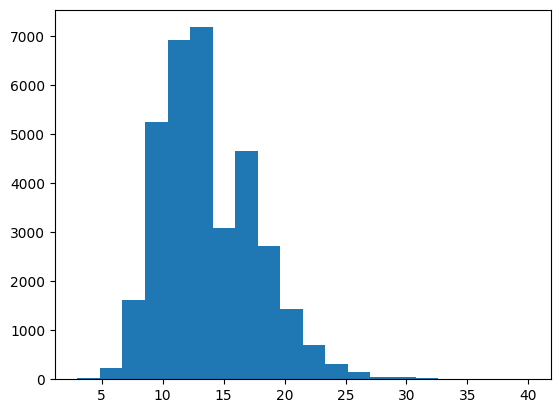

In [46]:
plt.hist(seq_lens,bins=20)
plt.show()

In [60]:
def DatasetGenerator(df,img_enc,tokenizer,max_len=26,vocab_len=vocab_len):
    while 1:
        for index, row in df.iterrows():
            img = row['Image']
            caption = row['Caption']
            encoding = img_enc[img]
            in_img, in_seq, output_ = Create_Sequences(tokenizer, max_len, caption.replace('  ',' ').split(' '), encoding,vocab_len)
            yield ((in_img, in_seq), output_)

def Create_Sequences(tokenizer, max_len, caption, encoding,vocab_len):
    x1,x2,y=[],[],[]
    
    seq = tokenizer.texts_to_sequences([caption])[0]
        
    for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
            
        in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
            
        out_seq = to_categorical([out_seq], num_classes=vocab_len)[0]
            
        x1.append(encoding) 
        x2.append(in_seq)  
        y.append(out_seq)  
            
    return np.array(x1), np.array(x2), np.array(y)

In [161]:
input1 = Input(shape=(2048,))
e_img1 = Dropout(0.5)(input1)
e_img2 = Dense(units=256,activation='relu')(e_img1)

input2 = Input(shape=(26,))
e_seq1 = Embedding(vocab_len, output_dim=256, mask_zero=True)(input2)
e_seq2 = Dropout(0.5)(e_seq1)
e_seq3 = LSTM(256)(e_seq2)

decoder_in = add([e_img2,e_seq3])
decoder1 = Dense(128, activation='relu')(decoder_in)
decoder_out = Dense(vocab_len, activation='softmax')(decoder1)

model=Model(inputs=[input1,input2],outputs=decoder_out)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [162]:
generator = DatasetGenerator(train,img_enc,tokenizer)
model.fit(generator, epochs=15, steps_per_epoch= len(train)//256, verbose=1)

Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 7.2915
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 5.8451
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 5.2918
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.5458
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 5.2347
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.0363
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 5.1637
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.9192
Epoch 9/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 4.8855
Epoch 10/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 4.9804
Epoch 11/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 4.8982
Epoch 12/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 4.8670
Epoch 13/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.7242
Epoch 14/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.7045
Epoch 15/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 7

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

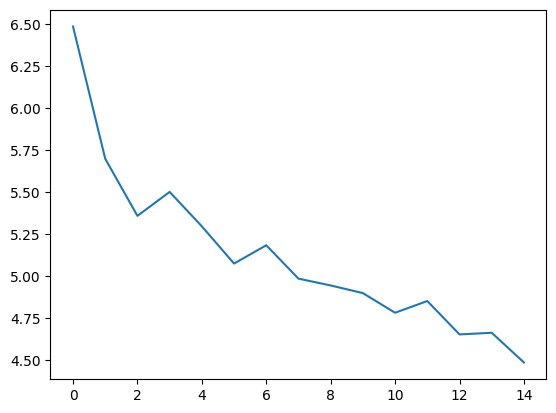

In [163]:
from seaborn import lineplot
lineplot(x=np.arange(0,15,1),y=list(model.history.history.values())[0])

In [152]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length=26):
    in_text = 'sos'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([np.array([photo]), np.array(sequence)])
        pred = np.argmax(pred, axis=-1)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        
        if word == 'eos':
            break
        
    
    return in_text

In [171]:
generate_desc(model, tokenizer, photo=img_enc['3476237185_9389c536a3.jpg'], max_length=26)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'sos a man is in a red red red red ball eos'

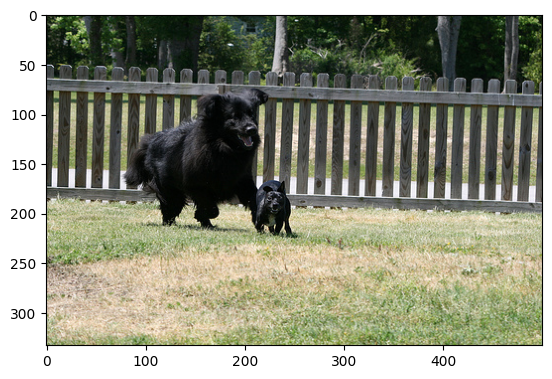

In [170]:
img=plt.imread('/kaggle/input/flickr8k/Images/3476237185_9389c536a3.jpg')
plt.imshow(img)
plt.show()

In [ ]:
from IPython.display import FileLink 
FileLink(r'/kaggle/working/encoding_train.pkl')

In [126]:
train.head(20)

,Image,Caption
0,3164347907_2813f8ff0b.jpg,sos two people outside in the snow taking pict...
1,2602083686_e8a1af69cf.jpg,sos two ladies are wearing nothing except body...
2,2847859796_4d9cb0d31f.jpg,sos a girl with goggles on in a pool eos
3,3254645823_a7c072481c.jpg,sos two snowboarders in the air above snow eos
4,3226541300_6c81711e8e.jpg,sos two men in magenta costumes performing eos
5,2955099064_1815b00825.jpg,sos three men with football in air eos
6,537758332_8beb9cf522.jpg,sos two little girls slide down an inflated sl...
7,2716457668_187a6d2b1c.jpg,sos a child with a mohawk is wearing dark sung...
8,3599124739_b7e60cf477.jpg,sos two small girls laugh as a wave hits them ...
9,3386953179_84c2d7922f.jpg,sos a skier makes the only path on an empty mo...
